<a href="https://colab.research.google.com/github/4nands/L20251022/blob/main/L20251120.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[0 1 0 1]
[0 1 2 3]


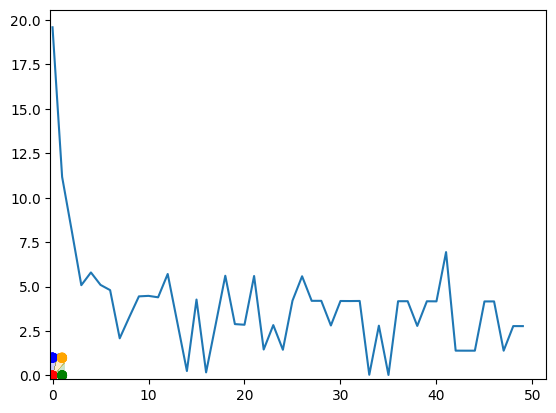

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def onehot(x):

  k=np.max(x)+1
  y = np.identity(k)

  return y[x]

def softmax(x):

  c = np.max(x,axis=-1,keepdims=True)
  e = np.exp(x-c)
  z = np.sum(e,axis=-1,keepdims=True)

  return e/z


class Module:

  def __init__(self):

    self.ps,self.gs = [],[]
    self.inputs = None
    self.out = None

def zeros_ps(ps):

  gs = []

  for p in ps:

    gs += [np.zeros_like(p)]

  return gs

class ReLU(Module):

  def __init__(self):
    super().__init__()
    self.mask = None

  def __call__(self,x):

    self.mask = x<0
    out = x.copy()
    out[self.mask] = 0

    return out

  def backward(self,dout):

    dout[self.mask] = 0

    return dout

class Sigmoid(Module):

  def __init__(self):
    super().__init__()


  def __call__(self,x):

    y = 1/(1+np.exp(-x))
    self.out = y

    return y

  def backward(self,dout):

    return dout*self.out * (1-self.out)


class Linear(Module):

  def __init__(self,d_in,d_out):

    super().__init__()

    self.ps = [
      np.random.randn(d_in,d_out),
      np.zeros(d_out)
    ]
    self.gs = zeros_ps(self.ps)


  def __call__(self,x):

    self.inputs = x

    return x @ self.ps[0] + self.ps[1]


  def backward(self,dout):

    self.gs[0][...] = self.inputs.T @ dout
    self.gs[1][...] = np.sum(dout)

    return dout @ self.ps[0].T


class Layers:

  def __init__(self,layers):

    self.layers = layers
    self.ps,self.gs = [],[]

    for l in layers:
      self.ps += l.ps
      self.gs += l.gs

  def __call__(self,x):

    for l in self.layers:
      x = l(x)

    return x

  def backward(self,dout):

    for l in reversed(self.layers):
      dout = l.backward(dout)

  def pred(self,x):

    out = self(x)

    return np.argmax(out,axis=-1)

  def optimizer(self,lr=0.1):

    for l in self.layers:
      l.optimizer(lr)

  def fit(self,optimizer,x0,t0,epochs=200,batch_size=10):

    l = []
    data_size = x0.shape[0]

    for i in range(epochs):
      idx = np.random.choice(data_size,batch_size,replace=False)
      x = x0[idx]
      t = t0[idx]
      n = x.shape[0]
      y = self(x)
      y = softmax(y)
      dout = (y-t)/n
      self.backward(dout)
      optimizer()
      l.append(loss(y,t))

    return l


def loss(y,t):
  eps = 1e-6

  loss = -np.sum(t*np.log(y+eps))

  return loss

def dataset(x,y,size=10,scale=0.1):

  X,Y = [],[]
  n = x.shape[1]
  for x0,y0 in zip(x,y):
    X.extend(x0+np.random.randn(size,n)*scale)
    Y.extend(np.full(size,y0))

  X = np.vstack(X)
  Y = np.hstack(Y)

  return X,onehot(Y)

class SGD:

  def __init__(self,ps,gs,lr=0.1):
    self.ps = ps
    self.gs = gs

    self.lr = 0.1

  def __call__(self):

    for p,g in zip(self.ps,self.gs):

      p -= self.lr*g

class Ada:

  def __init__(self,ps,gs,lr=0.1,beta=0.9):
    self.ps = ps
    self.gs = gs

    self.hs = zeros_ps(ps)

    self.lr = 0.1
    self.beta = beta

  def __call__(self):

    eps = 1e-6
    b = self.beta

    for p,g,h in zip(self.ps,self.gs,self.hs):

      h[...] = b*h + (1-b)*g*g

      p -= self.lr*g/(np.sqrt(h)+eps)

x = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([0,1,2,3])

x_train,y_train = dataset(x,y,size=10,scale=0.01)

y = onehot(y)

d_in = x.shape[1]
d_h = 4*d_in
d_out = y.shape[1]

layers = [
    Linear(d_in,d_h),
    ReLU(),
    Linear(d_h,d_out)
]


model = Layers(layers)
#optimizer = SGD(model.ps,model.gs,lr=0.1)
optimizer = Ada(model.ps,model.gs,lr=0.01)
print(model.pred(x))
loss = model.fit(optimizer,x_train,y_train,epochs=50,batch_size=10)
pred = model.pred(x)
print(pred)


plt.plot(loss)

colors=['red','blue','green','orange']

x_min = x_train.min()-0.2
x_max = x_train.max()+0.2

resolution = 200
x1 = np.linspace(x_min,x_max,resolution)
x2 = np.linspace(x_min,x_max,resolution)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.array([xx1.flatten(),xx2.flatten()]).T
z = model.pred(xx).reshape(xx1.shape)
cmap = ListedColormap(colors[:y.shape[1]])
plt.contourf(xx1,xx2,z,alpha=0.2,cmap=cmap)


c = [colors[i] for i in np.argmax(y_train,axis=1)]
plt.scatter(x_train[:,0],x_train[:,1],c=c)
#plt.show()

